In [1]:
# Imports

from pathlib import Path
import os
import pandas as pd
import numpy as np
import importlib.util
import time
import matplotlib.pyplot as plt

In [2]:
# Time window
START_DATE = '2025-01-01'
END_DATE = '2025-07-01'

# Simulation controls
N_SIMULATIONS = 1000000   
TOP_K_PLOTS = 10        

TOP_PERCENTILE = 0.01

# Risk free rate (annual)
RF_ANNUAL = 0.04

# Rebalancing mode, 'static' or 'random_daily'
REBALANCE_MODE = 'random_daily'

# Outputs
OUT_DIR = Path.cwd()
(OUT_DIR).mkdir(parents=True, exist_ok=True)
print(f"Output directory: {OUT_DIR}")
print(f"Rebalance mode: {REBALANCE_MODE}")

Output directory: c:\Users\andya\Desktop\Everything\ML\RL Port Optim\rl_markowitz_project\analysis\mc
Rebalance mode: random_daily


In [3]:
# Locate data dir
from pathlib import Path
data_dir = Path.cwd().parent.parent / 'data'
prices_csv = data_dir / 'etf_prices.csv'
prices = pd.read_csv(prices_csv, index_col=0, parse_dates=True)

# Slice by window and compute returns
prices = prices.loc[START_DATE:END_DATE]
if prices.empty:
    raise ValueError("No price data in the selected window.")

returns = prices.pct_change().dropna()
asset_list = returns.columns.tolist()
print(f"Assets: {len(asset_list)} -> {asset_list}")
print(f"Window: {returns.index.min().date()} -> {returns.index.max().date()} (n={len(returns)})")

Assets: 10 -> ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'VNQ', 'TLT', 'IEF', 'GLD', 'USO']
Window: 2025-01-03 -> 2025-07-01 (n=122)


In [4]:
TRADING_DAYS = 252

def max_drawdown(series: pd.Series) -> float:
    cum = (1 + series).cumprod()
    peak = cum.cummax()
    dd = (cum / peak) - 1.0
    return dd.min()

def portfolio_metrics(port_ret: pd.Series, rf_annual: float = 0.0) -> dict:
    if len(port_ret) == 0:
        return {"cagr": np.nan, "vol": np.nan, "sharpe": np.nan, "mdd": np.nan}
    # CAGR
    wealth = (1 + port_ret).cumprod()
    n_years = len(port_ret) / TRADING_DAYS
    cagr = wealth.iloc[-1] ** (1 / n_years) - 1 if n_years > 0 else np.nan
    # Volatility (annualized)
    vol = port_ret.std(ddof=1) * np.sqrt(TRADING_DAYS)
    # Sharpe (excess return over rf)
    rf_daily = rf_annual / TRADING_DAYS
    excess = port_ret - rf_daily
    sharpe = (excess.mean() * TRADING_DAYS) / vol if vol > 0 else np.nan
    # Max drawdown
    mdd = max_drawdown(port_ret)
    return {"cagr": cagr, "vol": vol, "sharpe": sharpe, "mdd": mdd}

def random_weights(n_assets: int) -> np.ndarray:
    w = np.random.rand(n_assets)
    s = w.sum()
    return (w / s) if s > 0 else np.ones(n_assets) / n_assets

def simulate_portfolios(returns: pd.DataFrame, n_sims: int, rf_annual: float = 0.0, mode: str = 'static', track_best: bool = False):
    """Simulate random portfolios.
    If track_best=True, also return a dict with the wealth path & metadata of the highest Sharpe simulation.
    Note: For 'random_daily' the stored wealth path corresponds exactly to the sampled daily random weights.
    """
    n_assets = returns.shape[1]
    n_days = returns.shape[0]
    all_weights = np.zeros((n_sims, n_assets))
    metrics = []
    best = {"sharpe": -np.inf, "idx": None, "wealth": None, "port_ret": None}

    if mode == 'static':
        for i in range(n_sims):
            w = random_weights(n_assets)
            all_weights[i, :] = w
            port_ret = (returns.values @ w)
            port_ret = pd.Series(port_ret, index=returns.index)
            m = portfolio_metrics(port_ret, rf_annual=rf_annual)
            m["final_wealth"] = float((1 + port_ret).cumprod().iloc[-1])
            m["idx"] = i
            metrics.append(m)
            if track_best and m["sharpe"] > best["sharpe"]:
                best.update({"sharpe": m["sharpe"], "idx": i, "wealth": (1+port_ret).cumprod().values.tolist(), "port_ret": port_ret.values.tolist()})
    elif mode == 'random_daily':
        # For random_daily, weights change every day; final weights snapshot is the last day's weights
        for i in range(n_sims):
            daily_w = np.apply_along_axis(lambda _: random_weights(n_assets), 1, np.zeros((n_days, n_assets)))
            port_ret_vals = (returns.values * daily_w).sum(axis=1)
            port_ret = pd.Series(port_ret_vals, index=returns.index)
            m = portfolio_metrics(port_ret, rf_annual=rf_annual)
            m["final_wealth"] = float((1 + port_ret).cumprod().iloc[-1])
            m["idx"] = i
            metrics.append(m)
            all_weights[i, :] = daily_w[-1]  # store last day weights only
            if track_best and m["sharpe"] > best["sharpe"]:
                best.update({"sharpe": m["sharpe"], "idx": i, "wealth": (1+port_ret).cumprod().values.tolist(), "port_ret": port_ret.values.tolist()})
    else:
        raise ValueError("Unsupported mode. Use 'static' or 'random_daily'.")

    metrics_df = pd.DataFrame(metrics)
    weights_df = pd.DataFrame(all_weights, columns=returns.columns)
    if track_best:
        return metrics_df, weights_df, best
    return metrics_df, weights_df

In [5]:
# Run simulation

start_t = time.time()
metrics_df, weights_df, best_sim = simulate_portfolios(returns, N_SIMULATIONS, rf_annual=RF_ANNUAL, mode=REBALANCE_MODE, track_best=True)
elapsed = time.time() - start_t

# Rank by Sharpe, then by final wealth
metrics_df = metrics_df.sort_values(["sharpe", "final_wealth"], ascending=[False, False]).reset_index(drop=True)
print(f"Simulations: {N_SIMULATIONS} in {elapsed:.2f}s | Mode: {REBALANCE_MODE}")
print("Top 10 portfolios (Sharpe):")
print(metrics_df.head(10))
print(f"\nBest simulation tracked on-the-fly: idx={best_sim['idx']} sharpe={best_sim['sharpe']:.4f}")

Simulations: 1000000 in 797.93s | Mode: random_daily
Top 10 portfolios (Sharpe):
       cagr       vol    sharpe       mdd  final_wealth     idx
0  0.457733  0.153622  2.269746 -0.080443      1.200165  390156
1  0.463750  0.164087  2.160501 -0.105083      1.202561  952552
2  0.429231  0.152446  2.156920 -0.097179      1.188747  600335
3  0.419873  0.151810  2.121945 -0.083373      1.184972  114063
4  0.406789  0.147587  2.115931 -0.090706      1.179673  914046
5  0.408295  0.148656  2.108804 -0.093331      1.180284    5483
6  0.419802  0.153277  2.102794 -0.094858      1.184943  896021
7  0.410925  0.150601  2.096061 -0.101071      1.181351  201865
8  0.386299  0.141783  2.092780 -0.090190      1.171323  707658
9  0.431438  0.158284  2.092289 -0.112771      1.189635  578431

Best simulation tracked on-the-fly: idx=390156 sharpe=2.2697


In [12]:
# Top percentile summary

cut = int(np.ceil(len(metrics_df) * (1 / 100.0)))
cut = max(cut, 1)
summary = metrics_df.head(cut).agg({"cagr": ["mean", "max"], "vol": ["mean", "min"], "sharpe": ["mean", "max"], "mdd": ["mean", "min"], "final_wealth": ["mean", "max"]})
print(f"\nTop {1}% summary over {cut} portfolios:")
print(summary)

cut = int(np.ceil(len(metrics_df) * (0.3 / 100.0)))
cut = max(cut, 1)
summary = metrics_df.head(cut).agg({"cagr": ["mean", "max"], "vol": ["mean", "min"], "sharpe": ["mean", "max"], "mdd": ["mean", "min"], "final_wealth": ["mean", "max"]})
print(f"\nTop {0.3}% summary over {cut} portfolios:")
print(summary)

cut = int(np.ceil(len(metrics_df) * (0.01 / 100.0)))
cut = max(cut, 1)
summary = metrics_df.head(cut).agg({"cagr": ["mean", "max"], "vol": ["mean", "min"], "sharpe": ["mean", "max"], "mdd": ["mean", "min"], "final_wealth": ["mean", "max"]})
print(f"\nTop {0.01}% summary over {cut} portfolios:")
print(summary)

cut = int(np.ceil(len(metrics_df) * (50 / 100.0)))
cut = max(cut, 1)
summary = metrics_df.head(cut).agg({"cagr": ["mean", "max"], "vol": ["mean", "min"], "sharpe": ["mean", "max"], "mdd": ["mean", "min"], "final_wealth": ["mean", "max"]})
print(f"\nTop {50}% summary over {cut} portfolios:")
print(summary)


Top 1% summary over 10000 portfolios:
          cagr       vol    sharpe       mdd  final_wealth
mean  0.321775  0.155513  1.613729 -0.102582      1.144562
max   0.463750       NaN  2.269746       NaN      1.202561
min        NaN  0.128307       NaN -0.139360           NaN

Top 0.3% summary over 3000 portfolios:
          cagr       vol    sharpe       mdd  final_wealth
mean  0.344665  0.154532  1.734260 -0.099779      1.154120
max   0.463750       NaN  2.269746       NaN      1.202561
min        NaN  0.131961       NaN -0.130617           NaN

Top 0.01% summary over 100 portfolios:
          cagr       vol    sharpe       mdd  final_wealth
mean  0.393919  0.151417  2.004412 -0.093722      1.174401
max   0.463750       NaN  2.269746       NaN      1.202561
min        NaN  0.135627       NaN -0.114011           NaN

Top 50% summary over 500000 portfolios:
          cagr       vol    sharpe       mdd  final_wealth
mean  0.210337  0.158212  1.030208 -0.115509      1.096704
max   0.463750

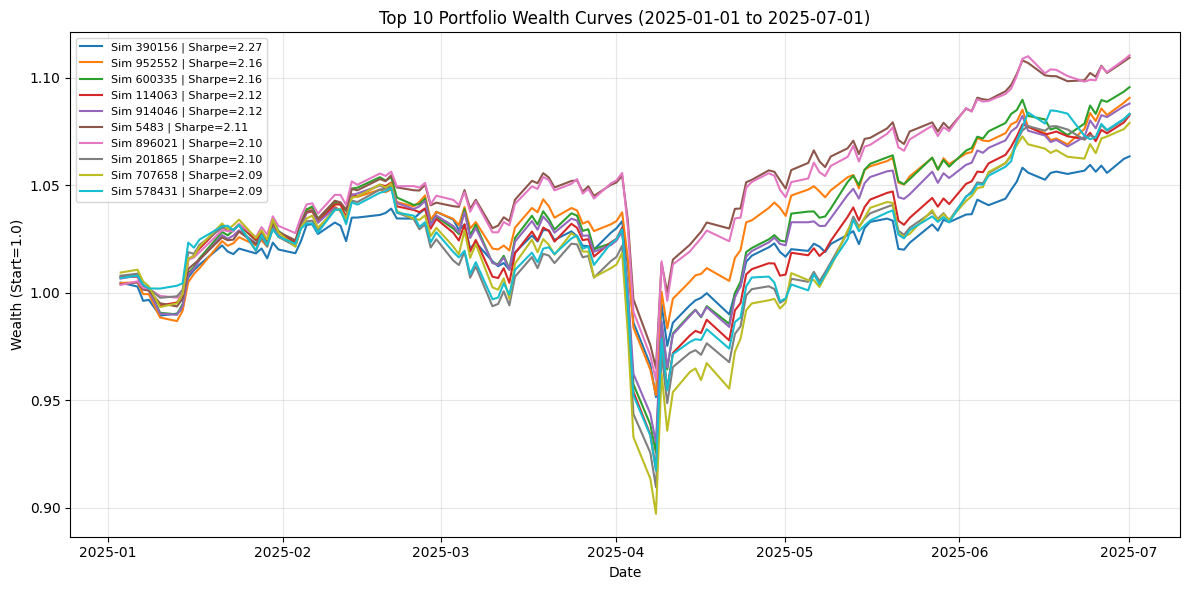

In [7]:
# Plot wealth curves for top portfolios

k = min(TOP_K_PLOTS, len(metrics_df))
fig, ax = plt.subplots(figsize=(12, 6))

for i in range(k):
    sim_idx = int(metrics_df.loc[i, 'idx'])
    w = weights_df.iloc[sim_idx].values
    port_ret = pd.Series(returns.values @ w, index=returns.index)
    wealth = (1 + port_ret).cumprod()
    ax.plot(wealth, label=f"Sim {sim_idx} | Sharpe={metrics_df.loc[i,'sharpe']:.2f}")

ax.set_title(f"Top {k} Portfolio Wealth Curves ({START_DATE} to {END_DATE})")
ax.set_xlabel("Date")
ax.set_ylabel("Wealth (Start=1.0)")
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.savefig(OUT_DIR / 'mc_wealth_topK.png', dpi=200, bbox_inches='tight')
plt.show()

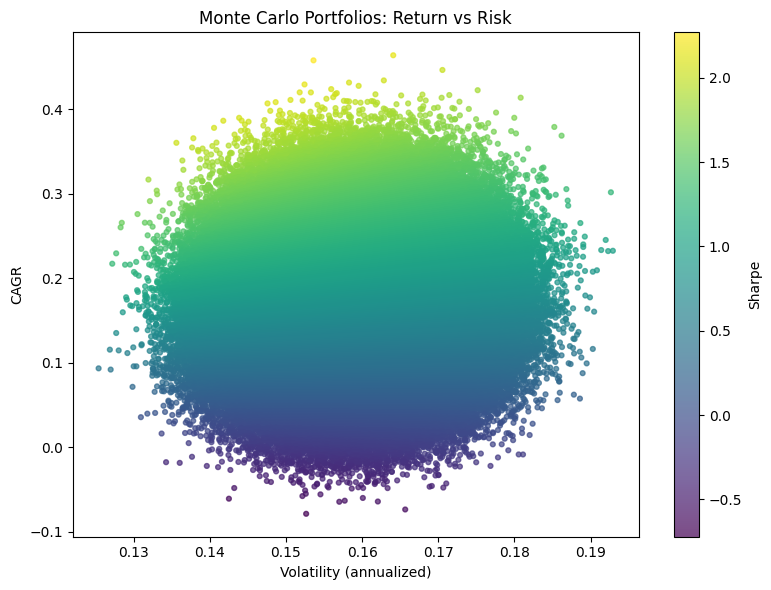

In [8]:
# Scatter: CAGR vs Volatility (colored by Sharpe)
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(metrics_df['vol'], metrics_df['cagr'], c=metrics_df['sharpe'], cmap='viridis', s=12, alpha=0.7)
ax.set_xlabel('Volatility (annualized)')
ax.set_ylabel('CAGR')
ax.set_title('Monte Carlo Portfolios: Return vs Risk')
cb = plt.colorbar(sc, ax=ax)
cb.set_label('Sharpe')
plt.tight_layout()
plt.savefig(OUT_DIR / 'mc_scatter_return_vs_risk.png', dpi=200, bbox_inches='tight')
plt.show()

In [9]:
# Save a single combined CSV with metrics, weights, and flags


n = len(metrics_df)
k = min(TOP_K_PLOTS, n)
cut = int(np.ceil(n * (TOP_PERCENTILE / 100.0)))
cut = max(cut, 1)

# Align weights to the sorted metrics order using original simulation index
weights_sorted = weights_df.iloc[metrics_df['idx'].astype(int)].reset_index(drop=True)
combined = pd.concat([metrics_df.reset_index(drop=True), weights_sorted], axis=1)

# Add flags and metadata
combined.insert(0, 'rank', range(1, n + 1))
combined['is_topK'] = combined['rank'] <= k
combined['is_top_percentile'] = combined['rank'] <= cut
combined['mode'] = REBALANCE_MODE
combined['start_date'] = START_DATE
combined['end_date'] = END_DATE
combined['rf_annual'] = RF_ANNUAL

out_csv = OUT_DIR / 'mc_results.csv'
combined.to_csv(out_csv, index=False)
print(f"Saved single CSV: {out_csv}")

# Save best simulation wealth path separately for overlay usage
if best_sim and best_sim.get('wealth') is not None:
    best_path_df = pd.DataFrame({
        'date': returns.index,
        'best_mc_wealth': best_sim['wealth'],
        'best_mc_daily_return': best_sim['port_ret']
    })
    best_path_csv = OUT_DIR / 'mc_best_path.csv'
    best_path_df.to_csv(best_path_csv, index=False)
    print(f"Best MC wealth path saved: {best_path_csv}")

# Keep plots already saved above
print("Plots saved:", OUT_DIR / 'mc_wealth_topK.png', ',', OUT_DIR / 'mc_scatter_return_vs_risk.png')

Saved single CSV: c:\Users\andya\Desktop\Everything\ML\RL Port Optim\rl_markowitz_project\analysis\mc\mc_results.csv
Best MC wealth path saved: c:\Users\andya\Desktop\Everything\ML\RL Port Optim\rl_markowitz_project\analysis\mc\mc_best_path.csv
Plots saved: c:\Users\andya\Desktop\Everything\ML\RL Port Optim\rl_markowitz_project\analysis\mc\mc_wealth_topK.png , c:\Users\andya\Desktop\Everything\ML\RL Port Optim\rl_markowitz_project\analysis\mc\mc_scatter_return_vs_risk.png
